## **障礙物觀點的 puzzle-based reshuffling**

### **集合**
---
$$
\begin{array}{ll}
   T & \text{時間集合，$T = \{1,2,3,...,|T|\}$}  \\
   N & \text{網格格點集合}  \\
   A & \text{格點間路徑集合}  \\
   R & \text{各類推盤集合，$R = \{0,1,2,...,|R|-1\}$}  \\
   \delta^{in}_{ri} & \text{推盤 $r\in R$ 流入格點 $i \in N$ 之節線集合， $\delta^{in}_{ri} \subset A$ } \\
   \delta^{out}_{ri} & \text{推盤 $r\in R$ 流出格點 $i \in N$ 之節線集合， $\delta^{out}_{ri} \subset A$ } \\
   V_i & \text{推盤垂直進出格點 $i \in N$ 之節線集合， $V_i \subset A$ } \\
   H_i & \text{推盤水平進出格點 $i \in N$ 之節線集合， $H_i \subset A$ } \\
   I & \text{推盤起始位置之集合，$I \subset N$} \\
   P & \text{推盤終點位置之集合，$P \subset N$} \\
\end{array}\\
$$

### **參數**
---

$$
\begin{array}{ll}
   M & \text{極大懲罰數} \\
   \epsilon & \text{極小的數} \\
   D & \text{虛擬迄點} \\
   S_i^r & \text{推盤 $r\in R$ 初始位置在格點 $i \in N$ 為1；反之為0} \\
   F_i^r & \text{推盤 $r\in R$ 終點位置在格點 $i \in N$ 為1；反之為0} \\
   Num^r & \text{各類推盤 $r \in R$ 數量} \\
   |T| & \text{揀貨時間上限} \\
   P_r & \text{推盤 $r\in R$ 的終點位置，$P_r \in N$} \\
\end{array}\\
$$

### **變數**
---
$$
\begin{array}{ll}
   f^{tr}_{ij} & \text{推盤 $r\in R$ 在時刻 $t \in T$ 自格點 $i \in N$ 移至格點 $j \in N$ 為1；反之為0}  \\
   x^t_r & \text{推盤 $r\in R$ 在時刻 $t \in T$ 抵達終點 $F_i^r$ 為1；反之為0} \\
   w & \text{出貨推盤盤送至揀貨點之最遲時刻，$w \in Integer^+$} \\
\end{array}\\
$$

In [1]:
from gurobipy import *

In [2]:
def print_dict(dict):
    print('{')
    for k, v in dict.items():
        print(f'\t{k}: {v}')
    print('}')
    
def print_2dlist(l):
    print('[')
    for row in l:
        print(f'\t{row}')
    print(']')

In [6]:
# import preprocess_obs
%run preprocess_obs.ipynb
# import output_obs
%run output_obs.ipynb

### **數學模式**
---
$$
\begin{array}{lll}
   Minimize & w + \epsilon *\displaystyle\sum_{r\in R} \displaystyle\sum_{t\in \{0\} \cup T} \displaystyle\sum_{(i,j) \in A, i \neq j} f^{tr}_{ij}\\
   \\
   Subject \quad To & \\
   \\
   \textbf{流量守恆}\\
   \\
   選一條出去(或沒有) & \displaystyle\sum_{(i,j) \in \delta^{out}_{ri}} f_{ij}^{0r} = S^r_i & \forall i \in N ; r \in R \\
   一條到終點(或沒有) & \displaystyle\sum_{(j,i) \in \delta^{in}_{ri}} f_{ji}^{|T|r} = F^r_i & \forall i \in N ; r \in R \backslash \{0\} \\
   各類推盤守恆 & \displaystyle\sum_{i \in N} \displaystyle\sum_{(j,i) \in \delta^{in}_{ri}} f_{ji}^{|T|r} = Num^r & \forall r \in R \\
   前時刻進=現時刻出 & \displaystyle\sum_{(j,i) \in \delta^{in}_{ri}} f_{ji}^{(t-1)r} = \displaystyle\sum_{(i,j) \in \delta^{out}_{ri}} f_{ij}^{tr} & \forall i \in N ; t \in T ; r \in R \\
    \\
    \textbf{碰撞限制} \\
    \\
    一點一托盤 & \displaystyle\sum_{r \in R} \displaystyle\sum_{(j,i) \in \delta^{in}_{ri}} f_{ji}^{tr} \leq 1 & \forall i \in N ; t \in \{0\} \cup T \\
    不可交換 & \displaystyle\sum_{r \in R} (f_{ji}^{tr} + f_{ij}^{tr}) \leq 1 & \forall i \in N ; (i,j) \in A,i \neq j ; t \in \{0\} \cup T \\
    水平進垂直出 & \displaystyle\sum_{r \in R} \displaystyle\sum_{(j_1,i) \in H_i} \displaystyle\sum_{(i,j_2) \in V_i} (f_{j_1i}^{tr} + f_{ij_2}^{tr}) \leq 1 & \forall i \in N ; t \in \{0\} \cup T \\
    垂直進水平出 & \displaystyle\sum_{r \in R} \displaystyle\sum_{(j_1,i) \in V_i} \displaystyle\sum_{(i,j_2) \in H_i} (f_{j_1i}^{tr} + f_{ij_2}^{tr}) \leq 1 & \forall i \in N ; t \in \{0\} \cup T \\
    \\
    \textbf{轉向限制} \\
    \\
    水平轉垂直 & \displaystyle\sum_{r \in R} \displaystyle\sum_{(j_1,i) \in H_i} f_{j_1i}^{(t-1)r} + \displaystyle\sum_{r \in R} \displaystyle\sum_{(i,j_2) \in V_i} f_{ij_2}^{tr} \leq 1 & \forall i \in N ; t \in T \\
    垂直轉水平 & \displaystyle\sum_{r \in R} \displaystyle\sum_{(j_1,i) \in V_i} f_{j_1i}^{(t-1)r} + \displaystyle\sum_{r \in R} \displaystyle\sum_{(i,j_2) \in H_i} f_{ij_2}^{tr} \leq 1 & \forall i \in N ; t \in T \\
    \\
    \textbf{時間限制} \\
    \\
    紀錄抵達終點時間 & \displaystyle\sum_{(P_r, j) \in A} f^{tr}_{P_rj} \geq x^t_r & \forall t \in \{0\} \cup T ; r \in R \backslash \{0\} \\
    至少經過終點一次 & \displaystyle\sum_{t \in \{0\} \cup T} x^t_r \geq 1 & \forall r \in R \backslash \{0\} \\
    最遲抵達終點時刻 & \displaystyle\sum_{t \in \{0\} \cup T} (t * x^t_r) \leq w & \forall r \in R \backslash \{0\} \\
    \\
    Bound & \\
          & f^{tr}_{ij} \in \{0,1\} & \forall r \in R ; (i,j) \in A ; t \in \{0\} \cup T \\
          & x^t_r \in \{0,1\} & \forall r \in R \backslash \{0\} ; t \in \{0\} \cup T\\
          & w \in Integer^+ \\
    \\
\end{array}\\            
$$

In [4]:
def runModelObs(map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, Vi, Hi, I, P, S_ri, F_ri, M, epsilon, Num):
    model = Model("Puzzle-Based Reshuffling")
    
    f = {}
    x = {}
    w = 0
    for t in [0]+T:
        for r in R:
            x[t,r] = model.addVar(vtype = "B", name = "x(%d,%d)" % (t,r))
            for i in N:
                for j in N:
                    f[t,r,i,j] = model.addVar(vtype = "B", name = "f(%d,%d,%d,%d)" % (t,r,i,j))
                    # x[t,r] = model.addVar(vtype = "B", name = "x(%d,%d)" % (t,r))
    
    w = model.addVar(vtype = "I", name = "w")
    
    for r in R:
        for i in N:
            # 時間 0，所有貨物 r 從起點出發遵守流量守恆
            model.addConstr(quicksum(f[0, r, i, j[1]] for j in Out_ri[i]) == S_ri[r][i], name = f"Start_R{r}_N{i}")
            # # 時間 T，所有貨物 r 抵達終點遵守流量守恆
            # if r != 0:
            #     model.addConstr(quicksum(f[T_ub, r, j[1], i] for j in In_ri[i]) == F_ri[r][i], name = f"End_R{r}_N{i}")
            # 所有相鄰時刻，同個點同個貨物要有一進一出
            for t in T:
                model.addConstr(quicksum(f[t-1, r, j[1], i] for j in In_ri[i]) == quicksum(f[t, r, i, j[1]] for j in Out_ri[i]),
                                name = f"Flow_balance_T{t}_R{r}_N{i}")
                
    # 時間 T，所有推盤類別 r 抵達終點，且同類推盤總和遵守流量守恆
    for r in R:
        model.addConstr(quicksum(f[T_ub, r, j[1], i] for i in N for j in In_ri[i]) == Num[r], name = f"End_R{r}")
                
    for t in [0]+T:
        for i in N:
            # 一個格點只能有一個貨物
            model.addConstr(quicksum(quicksum(f[t, r, j[1], i] for j in In_ri[i]) for r in R) <= 1, 
                            name = f"Grid_{i}_Limit_in_time_{t}")
            # 禁止交換
            for j in A:
                if i != j[1]:
                    model.addConstr(quicksum((f[t, r, j[1], i] + f[t, r, i, j[1]]) for r in R) <= 1, 
                                    name = f"No_swapped_{i}_{j[1]}")
            # 同時刻的進出方向不能交錯
            model.addConstr(quicksum(f[t, r, j1[1], i] for j1 in Hi[i] for r in R) + 
                            quicksum(f[t, r, i, j2[1]] for j2 in Vi[i] for r in R) <= 1,
                            name = f"H{i}_in_V{i}_out")
            model.addConstr(quicksum(f[t, r, j1[1], i] for j1 in Vi[i] for r in R) + 
                            quicksum(f[t, r, i, j2[1]] for j2 in Hi[i] for r in R) <= 1,
                            name = f"V{i}_in_H{i}_out")
            
    for t in T:
        for i in N:
            # 轉向限制停留 1 單位時間
            model.addConstr(quicksum(f[t-1, r, j1[1], i] for j1 in Hi[i] for r in R) + 
                            quicksum(f[t, r, i, j2[1]] for j2 in Vi[i] for r in R) <= 1,
                            name = f"H{i}_turn_V{i}")
            model.addConstr(quicksum(f[t-1, r, j1[1], i] for j1 in Vi[i] for r in R) + 
                            quicksum(f[t, r, i, j2[1]] for j2 in Hi[i] for r in R) <= 1,
                            name = f"V{i}_turn_H{i}")
    
    
    # print(f'target : {R[1:]}')
    # 紀錄推盤編號及抵達時間
    for t in [0]+T:
        for r in R[1:]:
            for endpos in P:
                if endpos[0] == r:
                    model.addConstr(quicksum(f[t, r, endpos[1], j[1]] for j in Out_ri[endpos[1]]) >= x[t,r], name = f"Finish_T{t}_R{r}")
                    
    # 至少經過一次終點
    for r in R[1:]:
        model.addConstr(quicksum(x[t,r] for t in [0]+T) >= 1,name = f"Finish_Position_R{r}")
    # 最遲時刻
    for r in R[1:]:
        model.addConstr(quicksum(t*x[t,r] for t in [0]+T) <= w, name = f"Time_Limit_R{r}")    
    
    A_neq = []
    for arc in A:
        if arc[0] != arc[1]:
            A_neq.append(arc)
    
    is_running = False
    timelimit = 2000
    model.Params.LogtoConsole = is_running  # 是否列出軟體求解過程
    model.Params.timeLimit = timelimit      # 求解時限
    model.setObjective(w + epsilon * quicksum(f[t,r,i,j] for t in [0]+T for r in R for (i,j) in A_neq) , GRB.MINIMIZE)
    model.setParam('MIPFocus', 1)  # 專注於提高下界
    model.optimize()

    return model



In [6]:
# def writeModelCsv(size, model, map_start):

def printModel(model, map_start):
    print("running time = ", model.Runtime)
    print("optimal value = ", model.objVal)
    """
    ans_map = []
    for row in map_start:
        ans_map.append(row.copy())
    for t in [0]+T:
        print('-' * 40)
        print(f"time period {t}")
        for row in ans_map:
            print('|', end = ' ')
            for col in row:
                if col == -1: col = ' X'
                print(f'{col:2}', end = ' ')
            print('|')

        ans_map = []
        for i in range(size[0]):
            row = [0] * size[1]
            ans_map.append(row)
        print()
        for r in R:
            for (i,j) in A:
                var_name = f"f({t},{r},{i},{j})"
                var = model.getVarByName(var_name)
                EPS = 1.e-6
                if var.X > EPS:
                    if i != j: 
                        print(var_name, var.X)
                    if r == 0:
                        ans_map[(j-1)//size[0]][(j-1)%size[1]] = ' X'
                    else:
                        ans_map[(j-1)//size[0]][(j-1)%size[1]] = r
    """
    print('-' * 40)
    

def runAnalyzeModelObs(size, model, map_start):
    if model.status == GRB.OPTIMAL:
        model.write("model_obs.lp")      # 可行約束條件
        # Print Optimal value and solution
        printModel(model, map_start)
        return model.Runtime, model.objVal
    
    elif model.status == GRB.TIME_LIMIT:
        print("Time out, cannot get a optimal solution")
        print('-' * 40)
        return 500, 0
        
    elif model.status == GRB.INFEASIBLE:
        model.computeIIS()
        model.write("model_obs.ilp")   # 寫出不可行的約束條件
        print("Infeasible, no solution found.")
        return 0, 0

In [27]:
# # 測試單一測資
# # # main test

# # # MIPFocus = 0, time = 6.858000040054321
# # # MIPFocus = 1, time = 20.997999906539917
# # # MIPFocus = 2, time = 6.663000106811523
# # # MIPFocus = 3, time = 6.937000036239624
# size = (3,3)
# n_sp = 4
# n_tar = 3
# id = 1
# # ########## TimeOut ###########
# # # size = (3,3)
# # # n_sp = 2
# # # n_tar = 6
# # # id = 3

# map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, Vi, Hi, I, P, S_ri, F_ri, M, epsilon, Num = preprocess(size, n_sp, n_tar, id)
# model = runModelObs(map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, Vi, Hi, I, P, S_ri, F_ri, M, epsilon, Num)
# runtime, obj = runAnalyzeModelObs(size, model, map_start)

running time =  0.6189999580383301
optimal value =  5.011
----------------------------------------
time period 0
|  X  0  2 |
|  0  3  0 |
|  0  X  1 |

f(0,0,1,4) 1.0
f(0,2,3,2) 1.0
f(0,3,5,6) 1.0
----------------------------------------
time period 1
|  0  2  0 |
|  X  0  3 |
|  0  X  1 |

f(1,0,8,5) 1.0
f(1,2,2,1) 1.0
----------------------------------------
time period 2
|  2  0  0 |
|  X  X  3 |
|  0  0  1 |

f(2,0,5,2) 1.0
f(2,1,9,8) 1.0
----------------------------------------
time period 3
|  2  X  0 |
|  X  0  3 |
|  0  1  0 |

f(3,0,4,5) 1.0
f(3,1,8,7) 1.0
f(3,3,6,9) 1.0
----------------------------------------
time period 4
|  2  X  0 |
|  0  X  0 |
|  1  0  3 |

f(4,2,1,4) 1.0
----------------------------------------
time period 5
|  0  X  0 |
|  2  X  0 |
|  1  0  3 |

----------------------------------------
time period 6
|  0  X  0 |
|  2  X  0 |
|  1  0  3 |

----------------------------------------
time period 7
|  0  X  0 |
|  2  X  0 |
|  1  0  3 |

-----------------

In [7]:
# run all graphform
import csv
import os
import math

def writeResultCSV(size):
    s = size
    
    datadict, tar_list = pairDataDict(size)

    folder = 'result/model_obs'
    os.makedirs(folder, exist_ok=True)
    
    with open(f'result/model_obs/{size[0]}x{size[1]}.csv', 'w') as f:
        w = csv.writer(f)
        w.writerow(['n_tar', 'n_sp', 'id', 'Runtime', 'Obj'])
        for n_tar, spacelist in datadict.items():
            for n_sp in spacelist:
                num = 10
                if s[0] == 3 and s[1] == 3:
                    if n_tar == 1 and n_sp == 8: num = 9
                    elif n_sp == 1: num = 9
                if s[0] >= 5: num = 5
                for id in range(num):    # 0~num-1
                    map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, Vi, Hi, I, P, S_ri, F_ri, M, epsilon, Num = preprocess(size, n_sp, n_tar, id)
                    model = runModelObs(map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, Vi, Hi, I, P, S_ri, F_ri, M, epsilon, Num)
                    runT, runObj = runAnalyzeModelObs(size, model, map_start)
                    # 記得處理 timeout 和 infeasible
                    w.writerow([n_tar, n_sp, id, runT, runObj])
                # runT, runObj = runModelObs(map_grid, map_start, map_end, T_ub, T, N, R, A, In_ri, Out_ri, Vi, Hi, I, P, S_ri, F_ri, M, epsilon, Num)

In [11]:
# 這邊是引入 output_obs 來做
# main

size = (4,4)
datadict, tar_list = pairDataDict(size)
print(datadict)
# 這行是跑所有測資，會非常久（註：之後要考慮加上 os 來判斷檔案是否存在）
# writeResultCSV(size)


{1: [2, 3, 4, 5, 8, 12, 15], 2: [2, 3, 4, 5, 8, 12, 14], 3: [2, 3, 4, 5, 8, 12, 13], 4: [2, 3, 4, 5, 8, 12], 5: [2, 3, 4, 5, 8, 11], 8: [2, 3, 4, 5, 8], 12: [2, 3, 4]}


-----new_dict----
{
	1: {2: 1.1753999948501588, 3: 0.5013000011444092, 4: 0.39019997119903566, 5: 0.3953999996185303, 8: 0.3754999876022339, 12: 0.3591999769210815, 15: 0.2675000190734863}
	2: {2: 34.14360003471374, 3: 17.27869999408722, 4: 2.720899987220764, 5: 1.9843999862670898, 8: 1.4620999574661255, 12: 1.3361000299453736, 14: 0.8593000173568726}
	3: {2: 200.58079998493196, 3: 36.809100008010866, 4: 80.96310005187988, 5: 7.041600012779236, 8: 2.4871000051498413, 12: 2.127400016784668, 13: 1.8121000051498413}
	4: {2: 333.8948000192642, 3: 332.5255000114441, 4: 106.16200006008148, 5: 65.43119997978211, 8: 15.01619999408722, 12: 5.0763999938964846}
	5: {2: 463.76329998970033, 3: 405.8576999664307, 4: 325.9670000076294, 5: 197.58929998874663, 8: 32.1422000169754, 11: 9.293300008773803}
	8: {2: 500.0, 3: 500.0, 4: 500.0, 5: 500.0, 8: 313.76879997253417}
	12: {2: 500.0, 3: 500.0, 4: 500.0}
}


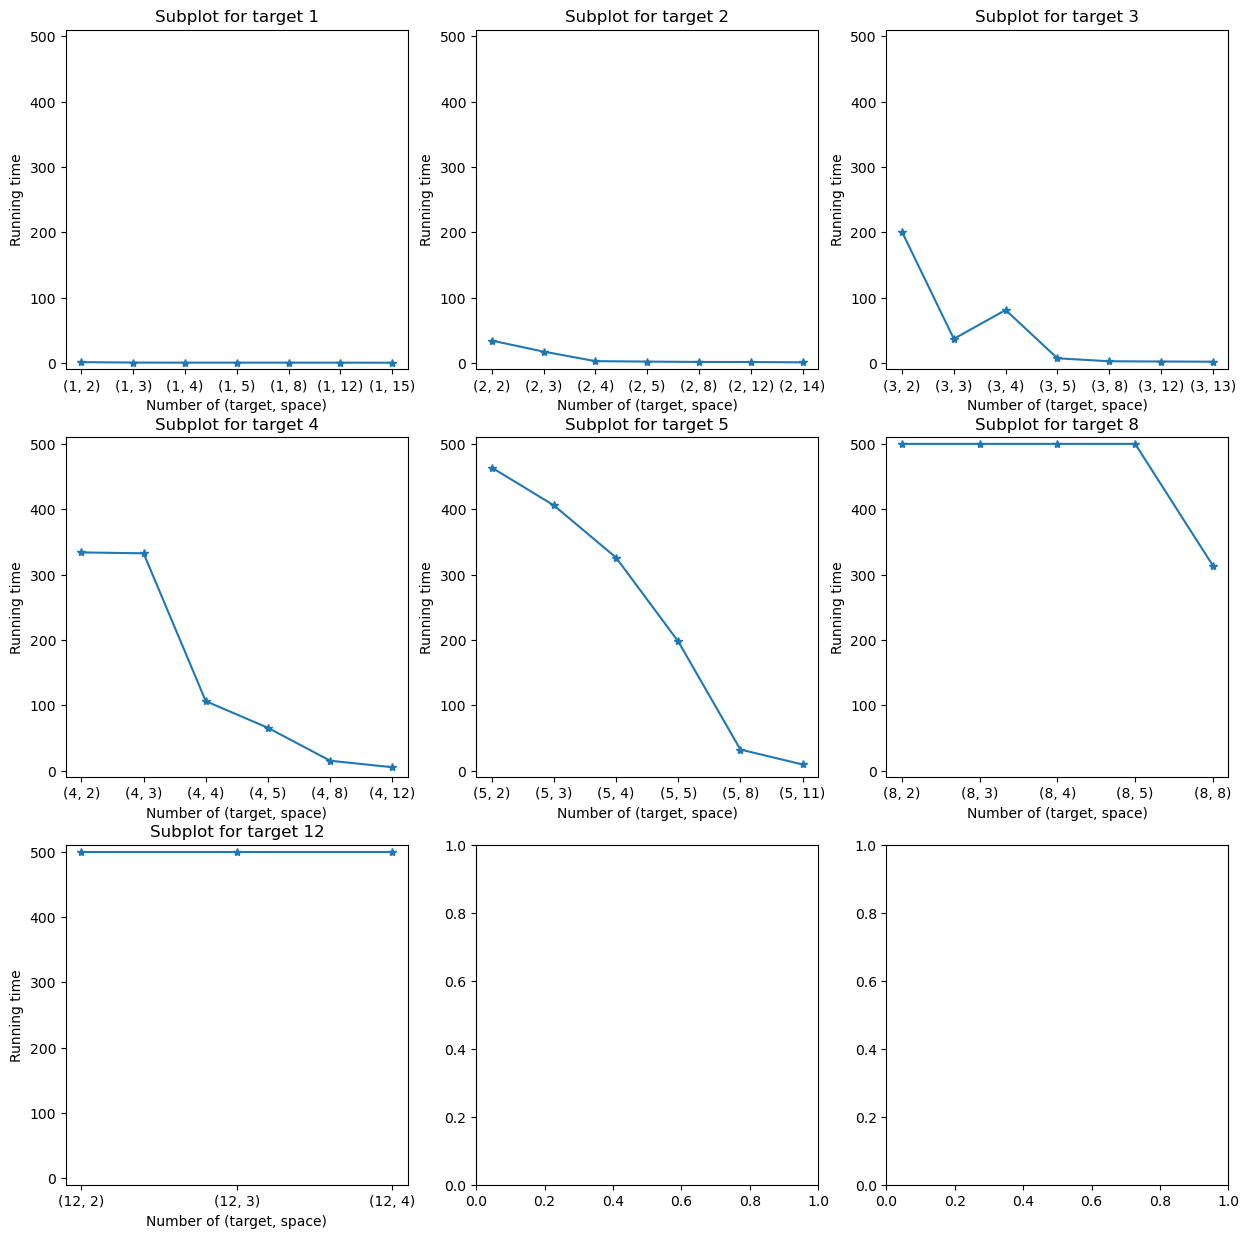

In [12]:
resultGraph(size, datadict, tar_list)